In [1]:
import os
os.chdir('/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2')

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
DATA_PATH = './data/data_25ms_h=50%_16mfcc_RMT-DPR+HRK.json'
SAVED_MODEL_PATH = './models/cnn2d/model.pt'
EPOCHS = 10
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [4]:
def get_data_splits(data_path: str, test_size: float = 0.05, val_size: float = 0.1):
    # read data from .json file
    with open(data_path, 'rb') as f:
        data = json.load(f)
    X, y, files = np.array(data['mfcc']), np.array(data['labels']), np.array(data['files'])

    # create train/validation/test splits
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
        X, y, files, test_size=test_size, random_state=23)
    X_train, X_val, y_train, y_val, files_train, files_val = train_test_split(
        X_train, y_train, files_train, test_size=val_size, random_state=23)

    # convert inputs from 2D to 3D arrays (number of segments, 13) -> (number of segments, 13, 1)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_val, X_test, y_train, y_val, y_test, files_train, files_val, files_test

In [5]:
def plot_history(history):
    r"""Plots accuracy/loss for training/validation set as a function of the epochs.

    Args:
        history:
            Training history of the model.

    Returns:
        : matplotlib figure
    """
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history['acc'] if isinstance(history, dict) else history.history['acc'], label='acc')
    axs[0].plot(history['val_acc'] if isinstance(history, dict) else history.history['val_acc'], label='val_acc')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy evaluation')

    # create loss subplot
    axs[1].plot(history['loss'] if isinstance(history, dict) else history.history['loss'], label='loss')
    axs[1].plot(history['val_loss'] if isinstance(history, dict) else history.history['val_loss'], label='val_loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Loss evaluation')
    plt.show()

In [6]:
def get_loss(
        model: torch.nn.Module,
        loss_fn,
        dataloader: torch.utils.data.DataLoader,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.eval()  # set the module in evaluation mode
    running_loss_per_epoch = 0.0
    running_number_of_samples_per_epoch = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)
            loss = loss_fn(outputs, labels)
            running_loss_per_epoch += loss.item() * len(labels)
            running_number_of_samples_per_epoch += len(labels)
    return running_loss_per_epoch / running_number_of_samples_per_epoch

In [7]:
def get_accuracy(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.eval()  # set the module in evaluation mode
    running_correct_samples_per_epoch = 0
    running_number_of_samples_per_epoch = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = torch.argmax(model(inputs), dim=1)
            number_of_correct_predictions = sum(y_pred == labels).item()
            running_correct_samples_per_epoch += number_of_correct_predictions
            running_number_of_samples_per_epoch += len(labels)
    return running_correct_samples_per_epoch / running_number_of_samples_per_epoch

In [8]:
def predict(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    model.eval()  # set the module in evaluation mode
    test_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, y = data  # get the inputs; data is a list of [inputs, labels]
            inputs, y = inputs.to(device), y.to(device)
            y_pred = torch.argmax(model(inputs), dim=1)
            test_preds.extend(list(y_pred.detach().numpy()))
    return np.array(test_preds)

In [9]:
def prepare_pt_dataloader(X: np.ndarray, y: np.ndarray, batch_size: int = 32, shuffle: bool = False):
    # torch wants the input in NCHW (instead of NHWC format)
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y, dtype=torch.int64))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes: int):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(1, 1), padding='valid')
        self.relu = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.maxpool1 = torch.nn.MaxPool2d((1, 1), stride=(1, 1))

        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=(1, 1), padding='valid')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.maxpool2 = torch.nn.MaxPool2d((1, 1), stride=(1, 1))

        self.flatten = torch.nn.Flatten()

        self.fc1 = torch.nn.Linear(32 * 1 * 16, 64)  # Adjusted input size
        self.dropout = torch.nn.Dropout(0.5)  # Adjusted dropout rate

        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool1(x)

        # conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.maxpool2(x)

        # flatten output
        x = self.flatten(x)

        # dense layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # last layer
        x = self.fc2(x)

        return x

In [11]:
class EarlyStopper:
    def __init__(self, monitor: str = 'val_loss', min_delta: float = 0.0, patience: int = 1):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.counter = 0
        self.min_val_loss = float('inf')
        self.max_val_acc = 0

    def early_stop(self, val):
        if self.monitor.endswith('loss'):
            if val < self.min_val_loss:
                self.min_val_loss = val
                self.counter = 0
            elif val > self.min_val_loss + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        elif self.monitor.endswith('acc'):
            if val > self.max_val_acc:
                self.max_val_acc = val
                self.counter = 0
            elif val < self.max_val_acc - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        else:
            raise ValueError(f'The only recognized quantities to be monitored are: loss, acc')

In [12]:
def build_pt_model(num_classes: int):
    model = CNN(num_classes)
    # print(torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 44, 13)))
    return model

In [13]:
def train_pt_model(
        model: torch.nn.Module,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        epochs: int = 40,
        patience: int = 5,
        batch_size: int = 32,
        learning_rate: float = 0.001
):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_dataloader = prepare_pt_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_dataloader = prepare_pt_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)

    early_stopper = EarlyStopper(monitor='val_acc', min_delta=0.001, patience=patience)

    #  creating history of logs
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(epochs):
        model.train()  # set the module in training mode  (you should set this here inside the `range(epochs)` loop)
        print(f'Epoch: {epoch+1}: Is model in train mode?', model.training)
        running_loss_per_epoch = 0.0
        running_number_of_correct_predictions_per_epoch = 0
        running_number_of_samples_per_epoch = 0
        for batch_idx, data in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()  # reset the gradients

            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).to(device)
            loss = loss_fn(outputs, labels)

            loss.backward()  # compute gradients during backpropagation
            optimizer.step()  # update the params

            # epoch statistics
            y_pred = torch.argmax(outputs, dim=1).to(device)
            running_loss_per_epoch += loss.item() * len(labels)
            running_number_of_correct_predictions_per_epoch += sum(y_pred == labels).item()
            running_number_of_samples_per_epoch += len(labels)

        train_loss = running_loss_per_epoch / running_number_of_samples_per_epoch
        train_acc = running_number_of_correct_predictions_per_epoch / running_number_of_samples_per_epoch
        val_loss = get_loss(model, loss_fn, val_dataloader, device=device)
        val_acc = get_accuracy(model, val_dataloader, device=device)

        history['loss'].append(train_loss)
        history['acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] "
              f"Epoch {epoch+1}/{epochs}\n"
              f"{len(train_dataloader)}/{len(train_dataloader)} [==============================] "
              f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - lr: {optimizer.state_dict()['param_groups'][0]['lr']}")

        if early_stopper.early_stop(val_acc):
            print(f'Early stopping criterion triggered: We did not have an increase in val_acc after {patience} epochs.')
            break

    return model, history

In [14]:
def eval_pt_model(
        model: torch.nn.Module,
        loss_fn,
        X_test,
        y_test,
        files_test,
        mapping=None,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
):
    test_dataloader = prepare_pt_dataloader(X_test, y_test, batch_size=32, shuffle=False)

    # get accumulated statistics
    test_loss = get_loss(model, loss_fn, test_dataloader, device=device)
    test_acc = get_accuracy(model, test_dataloader, device=device)
    print(f'\ntest_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}\n')

    # see specific examples
    # y_test_pred = predict(model, test_dataloader)
    # for file, y, yhat in zip(files_test, y_test, y_test_pred):
    #     if y == yhat:
    #         print(f'{file}: true: {y if mapping is None else mapping[y]}, '
    #               f'pred: {yhat if mapping is None else mapping[yhat]}')
    #     else:
    #         print(f'    WRONG!!! {file}: true: {y if mapping is None else mapping[y]}, '
    #               f'pred: {yhat if mapping is None else mapping[yhat]}')

X_train shape: (239459, 1, 16, 1), y_train shape: (239459,)
Epoch: 1: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 514.04it/s]


[2024-05-16 10:53:04] Epoch 1/10
7484/7484 [==============================] loss: 0.4289 - acc: 0.8009 - val_loss: 0.3698 - val_acc: 0.8276 - lr: 0.0001
Epoch: 2: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 509.46it/s]


[2024-05-16 10:53:50] Epoch 2/10
7484/7484 [==============================] loss: 0.3867 - acc: 0.8225 - val_loss: 0.3495 - val_acc: 0.8436 - lr: 0.0001
Epoch: 3: Is model in train mode? True


100%|██████████| 832/832 [00:02<00:00, 393.00it/s]


[2024-05-16 10:54:43] Epoch 3/10
7484/7484 [==============================] loss: 0.3741 - acc: 0.8290 - val_loss: 0.3365 - val_acc: 0.8484 - lr: 0.0001
Epoch: 4: Is model in train mode? True


100%|██████████| 832/832 [00:02<00:00, 407.60it/s]


[2024-05-16 10:55:34] Epoch 4/10
7484/7484 [==============================] loss: 0.3686 - acc: 0.8321 - val_loss: 0.3344 - val_acc: 0.8476 - lr: 0.0001
Epoch: 5: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 497.11it/s]


[2024-05-16 10:56:27] Epoch 5/10
7484/7484 [==============================] loss: 0.3657 - acc: 0.8335 - val_loss: 0.3315 - val_acc: 0.8509 - lr: 0.0001
Epoch: 6: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 517.10it/s]


[2024-05-16 10:57:13] Epoch 6/10
7484/7484 [==============================] loss: 0.3632 - acc: 0.8347 - val_loss: 0.3267 - val_acc: 0.8534 - lr: 0.0001
Epoch: 7: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 443.92it/s]


[2024-05-16 10:57:57] Epoch 7/10
7484/7484 [==============================] loss: 0.3603 - acc: 0.8361 - val_loss: 0.3298 - val_acc: 0.8534 - lr: 0.0001
Epoch: 8: Is model in train mode? True


100%|██████████| 832/832 [00:02<00:00, 392.94it/s]


[2024-05-16 10:58:45] Epoch 8/10
7484/7484 [==============================] loss: 0.3577 - acc: 0.8375 - val_loss: 0.3366 - val_acc: 0.8455 - lr: 0.0001
Epoch: 9: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 521.56it/s]


[2024-05-16 10:59:37] Epoch 9/10
7484/7484 [==============================] loss: 0.3558 - acc: 0.8379 - val_loss: 0.3280 - val_acc: 0.8495 - lr: 0.0001
Epoch: 10: Is model in train mode? True


100%|██████████| 832/832 [00:01<00:00, 518.89it/s]


[2024-05-16 11:00:22] Epoch 10/10
7484/7484 [==============================] loss: 0.3553 - acc: 0.8386 - val_loss: 0.3223 - val_acc: 0.8528 - lr: 0.0001


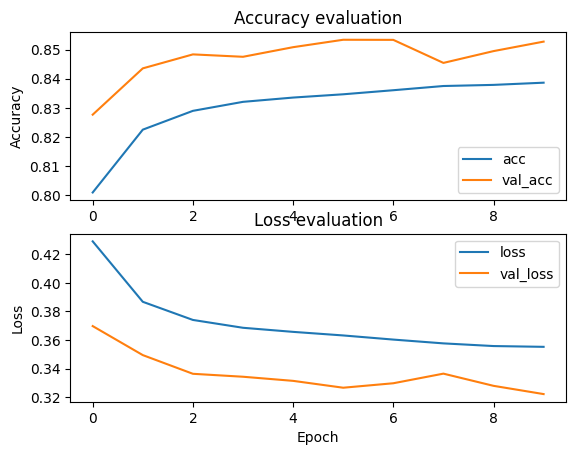

100%|██████████| 438/438 [00:00<00:00, 536.82it/s]



test_loss: 0.3278, test_acc: 0.8486



In [15]:
with open(DATA_PATH, 'rb') as f:
    data = json.load(f)
mapping = data['mapping']
NUM_CLASSES = len(mapping)

X_train, X_val, X_test, y_train, y_val, y_test, files_train, files_val, files_test = get_data_splits(DATA_PATH)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# build the model
pt_model = build_pt_model(NUM_CLASSES)

# train the model
pt_model, pt_history = train_pt_model(
    pt_model, X_train, y_train, X_val=X_val, y_val=y_val,
    epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE
)

# plot history
plot_history(pt_history)

# evaluate the model on test data
eval_pt_model(pt_model, torch.nn.CrossEntropyLoss(), X_test, y_test, files_test, mapping=mapping)

# save the model
scripted_model = torch.jit.script(pt_model)
scripted_model.save(SAVED_MODEL_PATH)